In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, Dropout, Flatten, Dense
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.externals import joblib

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_FILE = 'data/train_data.h5'
METADATA = 'metadata.npy'

f = h5py.File(DATA_FILE, 'r')
data_x = f['x']
data_y = f['y']
metadata = np.load(METADATA).item()

In [3]:
from sklearn.model_selection import train_test_split

data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.15, random_state=42)

In [4]:
import pandas as pd

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

# CNN

In [6]:
lr = 1e-3
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]
dropout_values = [0.25] * n_conv_layers

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], (3, 3), padding="same", kernel_initializer="he_uniform"))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(Dropout(dropout_values[i]))

model.add(Conv2D(12, (3, 3), padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy', recall, precision, f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 1, 1, 2048)        8192      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 128)         2359424   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 128)         512       
__________

In [7]:
model_filepath = 'models/CNN_Model.h5'
callbacks = [ModelCheckpoint(model_filepath, monitor='f1', verbose=0, save_best_only=True, mode="max")]
model.fit(X_train, y_train, batch_size=64, epochs=15,
          validation_data=(X_val, y_val), callbacks=callbacks)

Train on 4037 samples, validate on 713 samples
Epoch 1/15
4037/4037 [==============================] - 26s - loss: 1.4679 - acc: 0.5856 - recall: 0.2358 - precision: 0.7533 - f1: nan - val_loss: 1.7359 - val_acc: 0.7279 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: nan
Epoch 2/15
4037/4037 [==============================] - 21s - loss: 0.6207 - acc: 0.8241 - recall: 0.6879 - precision: 0.9138 - f1: 0.7826 - val_loss: 0.8813 - val_acc: 0.8569 - val_recall: 0.4418 - val_precision: 0.9801 - val_f1: 0.6060
Epoch 3/15
4037/4037 [==============================] - 27s - loss: 0.4056 - acc: 0.8771 - recall: 0.8177 - precision: 0.9164 - f1: 0.8635 - val_loss: 0.4745 - val_acc: 0.8640 - val_recall: 0.7784 - val_precision: 0.9389 - val_f1: 0.8509
Epoch 4/15
4037/4037 [==============================] - 24s - loss: 0.3235 - acc: 0.8994 - recall: 0.8553 - precision: 0.9295 - f1: 0.8904 - val_loss: 0.3371 - val_acc: 0.8934 - val_recall: 0.8541 - val_precision: 0.9216 - val_f1: 0.8864

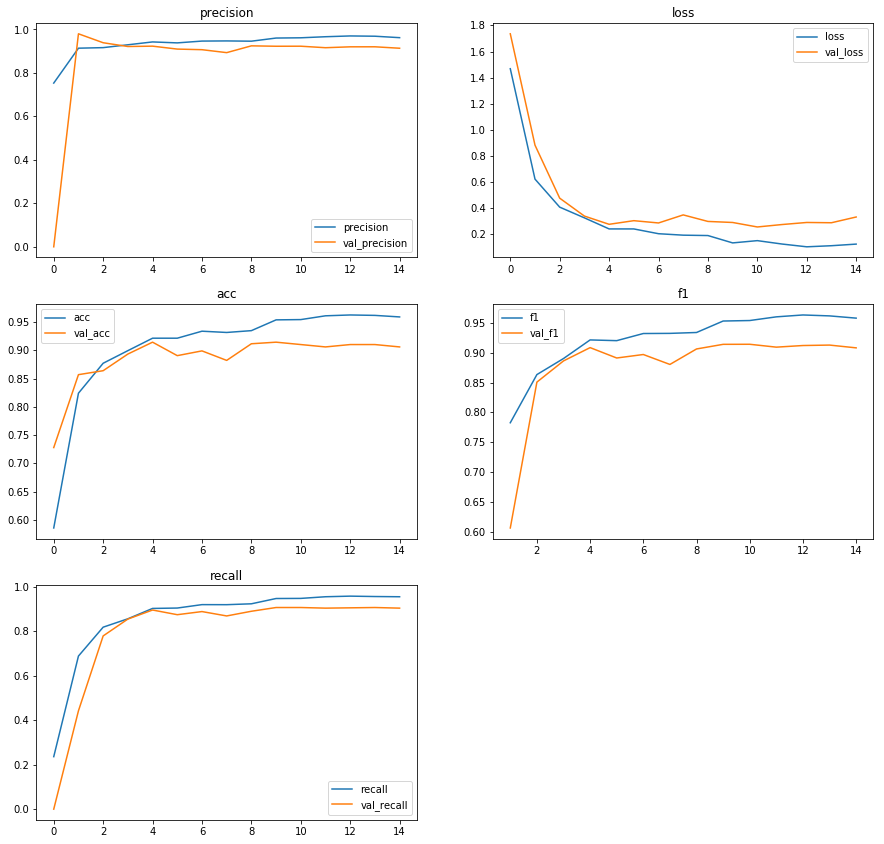

In [8]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [6]:
from keras.models import load_model

best_model = load_model('models/CNN_Model.h5', custom_objects={'recall': recall, 'precision': precision, 'f1': f1})

score, acc, recall, precision, f1 = best_model.evaluate(X_val, y_val, batch_size=64)

idx = len(results) + 1
results.loc[idx] = ['CNN', acc, precision, recall, f1]

results

576/713 [=======================>......] - ETA: 0s

,Model,Accuracy,Precision,Recall,F1
1,CNN,0.910238,0.920129,0.904628,0.912277


# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = 300
max_depth = 50

reshaped_x_train = X_train.reshape(X_train.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
rf_model.fit(reshaped_x_train, y_train.argmax(1))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [8]:
joblib.dump(rf_model, "models/RF_Model.h5")

['models/RF_Model.h5']

In [7]:
from sklearn import metrics

reshaped_x_val = X_val.reshape(X_val.shape[0], -1)

rf_model = joblib.load("models/RF_Model.h5")
rf_preds = rf_model.predict(reshaped_x_val)

idx = len(results) + 1
results.loc[idx] = ['Random Forests',
                       metrics.accuracy_score(y_val.argmax(1), rf_preds),
                       metrics.precision_score(y_val.argmax(1), rf_preds, average="macro"),
                       metrics.recall_score(y_val.argmax(1), rf_preds, average="macro"),
                       metrics.f1_score(y_val.argmax(1), rf_preds, average="macro") ]

results

,Model,Accuracy,Precision,Recall,F1
1,CNN,0.910238,0.920129,0.904628,0.912277
2,Random Forests,0.862553,0.883581,0.826914,0.838901


# Gradient Boosting

In [36]:
from xgboost import XGBClassifier

n_estimators = 250
max_depth = 50
learning_rate = 0.1

gb_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, silent=False)
gb_model.fit(reshaped_x_train, y_train.argmax(1))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=50,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [37]:
joblib.dump(gb_model, "models/GB_Model.h5")

['models/GB_Model.h5']

In [8]:
gb_model = joblib.load("models/GB_Model.h5")
gb_preds = gb_model.predict(reshaped_x_val)

idx = len(results) + 1
results.loc[idx] = ['Gradient Boosting',
                       metrics.accuracy_score(y_val.argmax(1), gb_preds),
                       metrics.precision_score(y_val.argmax(1), gb_preds, average="macro"),
                       metrics.recall_score(y_val.argmax(1), gb_preds, average="macro"),
                       metrics.f1_score(y_val.argmax(1), gb_preds, average="macro") ]

results

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Model,Accuracy,Precision,Recall,F1
1,CNN,0.910238,0.920129,0.904628,0.912277
2,Random Forests,0.862553,0.883581,0.826914,0.838901
3,Gradient Boosting,0.884993,0.880029,0.867321,0.871944
